In [85]:
import os
import sys
os.chdir('/home/ubuntu/speech2speech')
sys.path.append(os.path.abspath(os.path.dirname('/home/ubuntu/speech2speech') + '/..'))

import matplotlib.pyplot as plt
import math
import pandas as pd
from torchviz import make_dot, make_dot_from_trace
import random
from torchsummary import summary
from torchvision.utils import make_grid
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torch.nn as nn
import torch
import umap
from six.moves import xrange
from scipy.signal import savgol_filter
import pathlib
import librosa.display
import librosa
import numpy as np
import json
import argparse
from tqdm import tqdm
from playsound import playsound

from speech2speech.data_preprocessing.load_data import *
from speech2speech.models.model import Model
from speech2speech.models.training_utils import *
from torchsummary import summary

In [17]:
!ls

README.md    checkpoints  notebooks  plots    speech2speech
__init__.py  data	  output     scripts  test_num_embeddings_500


In [2]:
device = torch.device("cuda")

In [3]:
checkpoint_dir = os.path.join('/home/ubuntu/speech2speech/test_num_embeddings300_spectrogram_lr1em4/', 'checkpoints')

In [4]:
def get_latest_checkpoint(checkpoint_dir):
    '''
Return the latest checkpoint index and file in user provided directory
    '''
    all_files = {}
    file_list = glob.glob(os.path.join(checkpoint_dir, 'checkpoint*'))
    latest_file = max(file_list, key=os.path.getctime)
    
    return latest_file

In [5]:
get_latest_checkpoint(checkpoint_dir)

'/home/ubuntu/speech2speech/test_num_embeddings300_spectrogram_lr1em4/checkpoints/checkpoint_state_dict_1.pth'

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
spectrogram_dir= '/home/ubuntu/speech2speech/data/interim/spectogram_array_trim_30db'

In [26]:
files_np = list(glob.glob(os.path.join(spectrogram_dir, '*.*')))
speaker_id_dic(files_np)

{'264': 0,
 '298': 1,
 '269': 2,
 '329': 3,
 '314': 4,
 '340': 5,
 '255': 6,
 '299': 7,
 '250': 8,
 '243': 9,
 '234': 10,
 '351': 11,
 '300': 12,
 '361': 13,
 '281': 14,
 '287': 15,
 '259': 16,
 '310': 17,
 '297': 18,
 '248': 19,
 '256': 20,
 '244': 21,
 '288': 22,
 '263': 23,
 '245': 24,
 '236': 25,
 '227': 26,
 '225': 27,
 '280': 28,
 '295': 29,
 '293': 30,
 '228': 31,
 '240': 32,
 '270': 33,
 '233': 34,
 '363': 35,
 '311': 36,
 '262': 37,
 '276': 38,
 '231': 39,
 '230': 40,
 '305': 41,
 '257': 42,
 '374': 43,
 '339': 44,
 '251': 45,
 '252': 46,
 '268': 47,
 '335': 48,
 '317': 49,
 '241': 50,
 '267': 51,
 '265': 52,
 '237': 53,
 '343': 54,
 '294': 55,
 '312': 56,
 '304': 57,
 '232': 58,
 '258': 59,
 '247': 60,
 '334': 61,
 '278': 62,
 '364': 63,
 '261': 64,
 '226': 65,
 '360': 66,
 '282': 67,
 '330': 68,
 '239': 69,
 '246': 70,
 '238': 71,
 '316': 72,
 '283': 73,
 '273': 74,
 '347': 75,
 '318': 76,
 '274': 77,
 '285': 78,
 '333': 79,
 '313': 80,
 '303': 81,
 '272': 82,
 '292': 83,
 '

In [40]:
config_dict = {'num_hiddens' : 768,
'num_residual_layers' : 2,
'num_residual_hiddens' : 32,
'num_embeddings': 300,
'embedding_dim': 64,
'commitment_cost': 0.25,
'speaker_dic': {'264': 0,
 '298': 1,
 '269': 2,
 '329': 3,
 '314': 4,
 '340': 5,
 '255': 6,
 '299': 7,
 '250': 8,
 '243': 9,
 '234': 10,
 '351': 11,
 '300': 12,
 '361': 13,
 '281': 14,
 '287': 15,
 '259': 16,
 '310': 17,
 '297': 18,
 '248': 19,
 '256': 20,
 '244': 21,
 '288': 22,
 '263': 23,
 '245': 24,
 '236': 25,
 '227': 26,
 '225': 27,
 '280': 28,
 '295': 29,
 '293': 30,
 '228': 31,
 '240': 32,
 '270': 33,
 '233': 34,
 '363': 35,
 '311': 36,
 '262': 37,
 '276': 38,
 '231': 39,
 '230': 40,
 '305': 41,
 '257': 42,
 '374': 43,
 '339': 44,
 '251': 45,
 '252': 46,
 '268': 47,
 '335': 48,
 '317': 49,
 '241': 50,
 '267': 51,
 '265': 52,
 '237': 53,
 '343': 54,
 '294': 55,
 '312': 56,
 '304': 57,
 '232': 58,
 '258': 59,
 '247': 60,
 '334': 61,
 '278': 62,
 '364': 63,
 '261': 64,
 '226': 65,
 '360': 66,
 '282': 67,
 '330': 68,
 '239': 69,
 '246': 70,
 '238': 71,
 '316': 72,
 '283': 73,
 '273': 74,
 '347': 75,
 '318': 76,
 '274': 77,
 '285': 78,
 '333': 79,
 '313': 80,
 '303': 81,
 '272': 82,
 '292': 83,
 '253': 84,
 '266': 85,
 '275': 86,
 '308': 87,
 '307': 88,
 '326': 89,
 '323': 90,
 '315': 91,
 '286': 92,
 '249': 93,
 '277': 94,
 '301': 95,
 '376': 96,
 '306': 97,
 '345': 98,
 '362': 99,
 '254': 100,
 '279': 101,
 '302': 102,
 '341': 103,
 '271': 104,
 '260': 105,
 '229': 106,
 '336': 107,
 '284': 108},
'speaker_id' : '260',
'speaker_embedding_dim' : 20,
'decay' : 0,
'learning_rate' : 1e-4,
'batch_size': 10,
'time_length' : 100,
'num_epochs' : 20}

In [30]:
json.dump(config_dict, open('/home/ubuntu/speech2speech/test_num_embeddings300_spectrogram_lr1em4/checkpoints/config.json', 'w'))

In [31]:
config_path= '/home/ubuntu/speech2speech/test_num_embeddings300_spectrogram_lr1em4/checkpoints/config.json'

In [36]:
model_config = json.load(open(config_path, 'r'))

In [42]:
model = Model(model_config['num_hiddens'], model_config['num_residual_layers'], model_config['num_residual_hiddens'],
              model_config['num_embeddings'], model_config['embedding_dim'],
              model_config['commitment_cost'], model_config['speaker_dic'], model_config['speaker_id'], model_config['speaker_embedding_dim'], model_config['decay'], device).to(device)

In [44]:
def load_checkpoint(model, optimizer, filename):
    # Note: Input model & optimizer should be pre-defined.  This routine only updates their states.
    start_epoch = 0
    if os.path.isfile(filename):
        print("=> loading checkpoint '{}'".format(filename))
        checkpoint = torch.load(filename)
        start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        print("=> loaded checkpoint '{}' (epoch {})"
                  .format(filename, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(filename))

    return model, optimizer, start_epoch

In [103]:
load_sample_input = os.path.join(spectrogram_dir, 'trim_spec_p260_011.npy')

In [104]:
def load_one_sample(file, max_col):
    load_x = np.load(file)
    x = np.zeros((load_x.shape[0], max_col), dtype=np.float32)
    c = min(max_col, load_x.shape[1])
    x[:load_x.shape[0], :c] = load_x[:, :c]
    x = torch.tensor(x, device='cpu').float()
    trial_y = file.split('/')[-1][-11:-8]
    trial_y = torch.tensor(int(trial_y), device='cpu').float()
    return x, trial_y

In [105]:
x, y = preprocessing(load_sample_input, 50)

In [106]:
data = x.unsqueeze(0).to(device)

In [107]:
vq_loss, data_recon, perplexity = model(data)

In [110]:
experiment_name = '/home/ubuntu/speech2speech/test_num_embeddings300_spectrogram_lr1em4'

In [111]:
def spectrogram_to_audio(data, data_recon, output_dir, plots_dir):
    data_np = (data.squeeze(0).to(torch.device("cpu"))).detach().numpy();
    data_np = librosa.db_to_amplitude(data_np)
    data_griffin_lim = librosa.griffinlim(data_np)
    data_recon_np = (data_recon.squeeze(0).to(torch.device("cpu"))).detach().numpy();
    data_recon_np = librosa.db_to_amplitude(data_recon_np)
    data_recon_griffin_lim = librosa.griffinlim(data_recon_np)
    
    
    fig = plt.figure(figsize=(16, 8))
    ax = plt.subplot(2,1,1)
    output_path = plots_dir  + '.png'
    source_aud_path = output_dir + '_input_' + '.wav'
    target_aud_path = output_dir + '_output_' + '.wav'
    
    librosa.display.waveplot(data_griffin_lim, color = 'g')
    plt.title('Source Audio')
    plt.xlabel('')
    plt.subplot(2,1,2, sharex=ax, sharey=ax)
    plt.title('Target Audio')
    librosa.display.waveplot(5*data_recon_griffin_lim, color = 'b')
    plt.tight_layout()
    fig.savefig(output_path)
    
    librosa.output.write_wav(source_aud_path,data_griffin_lim, 16384)
    librosa.output.write_wav(target_aud_path,data_recon_griffin_lim, 16384)

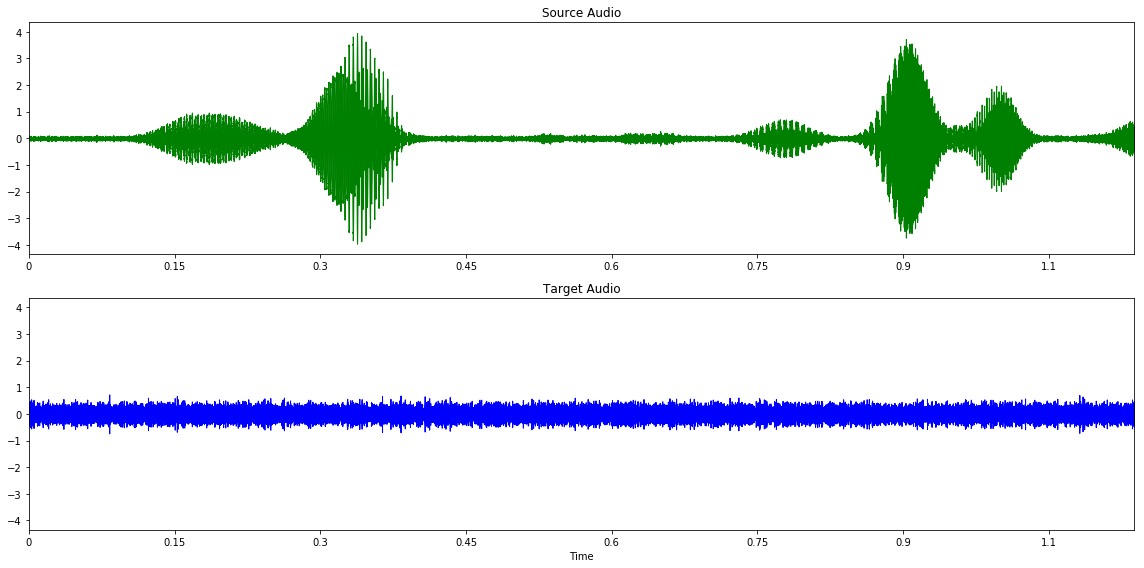

In [112]:
spectrogram_to_audio(data, data_recon, os.path.join(experiment_name, 'output'), os.path.join(experiment_name, 'plots'))

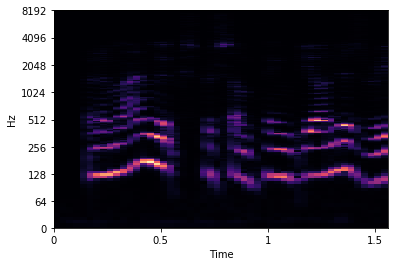

In [116]:
data_np = (data[0].to(torch.device("cpu"))).detach().numpy()
#data_np = librosa.amplitude_to_db(abs(data_np))
librosa.display.specshow(data_np, sr=16384, x_axis='time', y_axis='log')

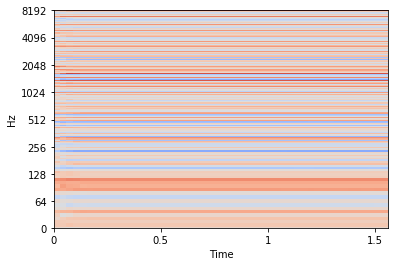

In [117]:
data_recon_np = (data_recon[0].to(torch.device("cpu"))).detach().numpy()
#data_recon_np = librosa.amplitude_to_db(abs(data_recon_np))
librosa.display.specshow(data_recon_np, sr=16384, x_axis='time', y_axis='log')

FileNotFoundError: [Errno 2] No such file or directory: '/home/ubuntu/voice_conversion/data/output/plots//300_db_lr1em3_spec_plot_0.png'

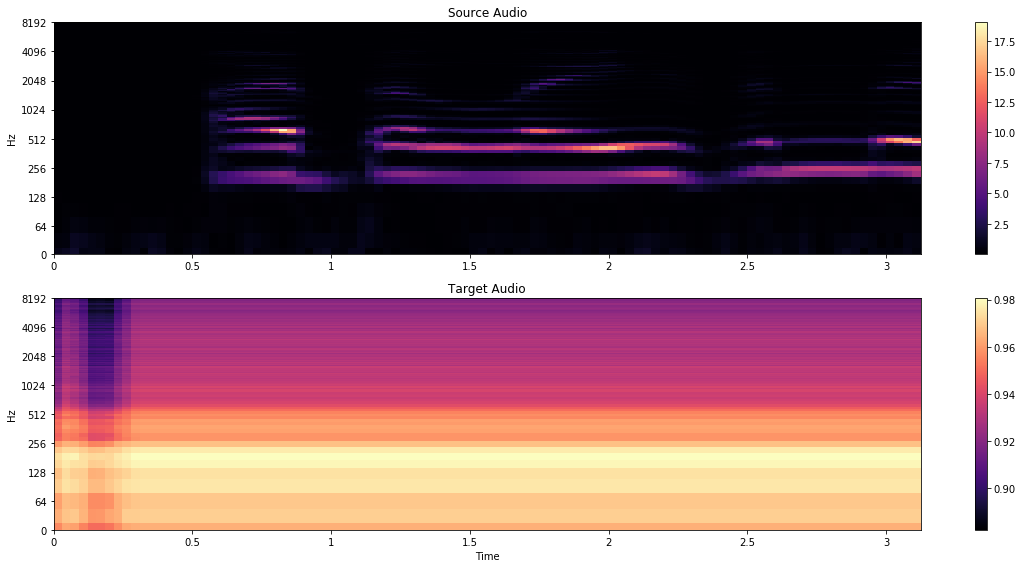

In [48]:

for i in range(len(data)):
    data_np = (data[i].to(torch.device("cpu"))).detach().numpy();
    data_np = librosa.db_to_amplitude(data_np)
    data_griffin_lim = librosa.griffinlim(data_np)
    data_recon_np = (data_recon[i].to(torch.device("cpu"))).detach().numpy();
    data_recon_np = librosa.db_to_amplitude(data_recon_np)
    data_recon_griffin_lim = librosa.griffinlim(data_recon_np)
    
    fig = plt.figure(figsize=(16, 8))
    ax = plt.subplot(2,1,1)
    output_path = '/home/ubuntu/voice_conversion/data/output/plots//300_db_lr1em3_spec_plot_' + str(i) + '.png'

    librosa.display.specshow(data_np, sr=16384, x_axis='time', y_axis='log')
    plt.title('Source Audio')
    plt.xlabel('')
    plt.colorbar()
    plt.subplot(2,1,2, sharex=ax, sharey=ax)
    plt.title('Target Audio')
    librosa.display.specshow(data_recon_np, sr=16384, x_axis='time', y_axis='log')
    plt.colorbar()
    plt.tight_layout()
    fig.savefig(output_path)

In [120]:
tensordataset = spectrograms_to_torch_dataset(files_np, 50)

train_dataset, val_dataset, test_dataset = split_dataset(
    tensordataset, 0.8, 0.1)

training_loader, validation_loader = train_val_data_loaders(train_dataset, val_dataset, batch_size)

NameError: name 'batch_size' is not defined

In [118]:
(data, _) = next(iter(training_loader))
data = data.to(device)

vq_loss, data_recon, perplexity = model(data)

NameError: name 'training_loader' is not defined

In [29]:
np.any(data[7].to(torch.device("cpu")).numpy() < 0 )

False

In [143]:
model.eval() # enter evaluation mode
val_res_recon_error = []
train_res_perplexity = []
epoch_loss = 0
with torch.no_grad():
    for epoch in range(num_epochs):
        std, _ = std_mean_dataloader(validation_loader)
        for i, (x, _) in enumerate(validation_loader):
            batch_X = x.to(device)
            # forward pass
            vq_loss, data_recon, perplexity = model(batch_X)
            recon_error = F.mse_loss(data_recon, x.cuda()) / std
            loss = recon_error + vq_loss
            epoch_loss += loss.item()

            if (i+1) % 10 == 0:
                print ("Epoch[{}/{}], Step [{}/{}], recon_error: {:.4f}, perplexity: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, len(training_loader), recon_error.item(), perplexity.item()))
                
        val_res_recon_error.append(recon_error.item())
        train_res_perplexity.append(perplexity.item())
        epoch_loss

Epoch[1/20], Step [10/3540], recon_error: 1.0074, perplexity: 11.1514
Epoch[1/20], Step [20/3540], recon_error: 0.7826, perplexity: 8.2006
Epoch[1/20], Step [30/3540], recon_error: 0.8856, perplexity: 9.9572
Epoch[1/20], Step [40/3540], recon_error: 1.2405, perplexity: 10.7006
Epoch[1/20], Step [50/3540], recon_error: 1.5537, perplexity: 12.6538
Epoch[1/20], Step [60/3540], recon_error: 0.7761, perplexity: 10.9095
Epoch[1/20], Step [70/3540], recon_error: 0.9391, perplexity: 11.9851
Epoch[1/20], Step [80/3540], recon_error: 0.9424, perplexity: 10.9733
Epoch[1/20], Step [90/3540], recon_error: 1.4172, perplexity: 14.9323
Epoch[1/20], Step [100/3540], recon_error: 1.2381, perplexity: 12.9405
Epoch[1/20], Step [110/3540], recon_error: 1.1825, perplexity: 11.6221
Epoch[1/20], Step [120/3540], recon_error: 1.2339, perplexity: 13.6039
Epoch[1/20], Step [130/3540], recon_error: 1.0449, perplexity: 10.7599
Epoch[1/20], Step [140/3540], recon_error: 1.0384, perplexity: 10.0622
Epoch[1/20], Step

Epoch[3/20], Step [300/3540], recon_error: 1.0436, perplexity: 8.6656
Epoch[3/20], Step [310/3540], recon_error: 0.9354, perplexity: 7.8121
Epoch[3/20], Step [320/3540], recon_error: 1.2266, perplexity: 14.5931
Epoch[3/20], Step [330/3540], recon_error: 0.9687, perplexity: 10.3562
Epoch[3/20], Step [340/3540], recon_error: 1.2561, perplexity: 11.6979
Epoch[3/20], Step [350/3540], recon_error: 1.1229, perplexity: 9.9681
Epoch[3/20], Step [360/3540], recon_error: 1.5171, perplexity: 12.8567
Epoch[3/20], Step [370/3540], recon_error: 1.2291, perplexity: 10.8598
Epoch[3/20], Step [380/3540], recon_error: 0.7588, perplexity: 9.1148
Epoch[3/20], Step [390/3540], recon_error: 1.2003, perplexity: 13.5682
Epoch[3/20], Step [400/3540], recon_error: 1.2946, perplexity: 10.7736
Epoch[3/20], Step [410/3540], recon_error: 1.8538, perplexity: 15.5671
Epoch[3/20], Step [420/3540], recon_error: 1.8751, perplexity: 12.1972
Epoch[3/20], Step [430/3540], recon_error: 0.8899, perplexity: 8.6812
Epoch[3/20]

Epoch[6/20], Step [150/3540], recon_error: 1.1061, perplexity: 11.3519
Epoch[6/20], Step [160/3540], recon_error: 1.7499, perplexity: 12.5489
Epoch[6/20], Step [170/3540], recon_error: 0.5830, perplexity: 9.0405
Epoch[6/20], Step [180/3540], recon_error: 1.0406, perplexity: 14.0528
Epoch[6/20], Step [190/3540], recon_error: 0.7007, perplexity: 9.5838
Epoch[6/20], Step [200/3540], recon_error: 1.1446, perplexity: 13.7666
Epoch[6/20], Step [210/3540], recon_error: 1.0301, perplexity: 10.0067
Epoch[6/20], Step [220/3540], recon_error: 1.1531, perplexity: 13.5757
Epoch[6/20], Step [230/3540], recon_error: 1.3126, perplexity: 14.2747
Epoch[6/20], Step [240/3540], recon_error: 0.8427, perplexity: 9.0798
Epoch[6/20], Step [250/3540], recon_error: 1.2208, perplexity: 11.1854
Epoch[6/20], Step [260/3540], recon_error: 0.8891, perplexity: 11.5413
Epoch[6/20], Step [270/3540], recon_error: 1.3554, perplexity: 17.9548
Epoch[6/20], Step [280/3540], recon_error: 0.7461, perplexity: 8.8158
Epoch[6/20

Epoch[8/20], Step [430/3540], recon_error: 1.1970, perplexity: 12.0988
Epoch[8/20], Step [440/3540], recon_error: 0.8360, perplexity: 10.8922
Epoch[9/20], Step [10/3540], recon_error: 1.3080, perplexity: 18.2184
Epoch[9/20], Step [20/3540], recon_error: 0.6662, perplexity: 7.9751
Epoch[9/20], Step [30/3540], recon_error: 0.8193, perplexity: 8.2363
Epoch[9/20], Step [40/3540], recon_error: 0.9717, perplexity: 11.5882
Epoch[9/20], Step [50/3540], recon_error: 1.0422, perplexity: 10.4335
Epoch[9/20], Step [60/3540], recon_error: 0.7909, perplexity: 15.2585
Epoch[9/20], Step [70/3540], recon_error: 0.7517, perplexity: 12.6264
Epoch[9/20], Step [80/3540], recon_error: 0.7097, perplexity: 10.9817
Epoch[9/20], Step [90/3540], recon_error: 0.9367, perplexity: 14.1036
Epoch[9/20], Step [100/3540], recon_error: 0.7146, perplexity: 11.6753
Epoch[9/20], Step [110/3540], recon_error: 0.8595, perplexity: 12.7711
Epoch[9/20], Step [120/3540], recon_error: 0.8894, perplexity: 14.9724
Epoch[9/20], Step

Epoch[11/20], Step [270/3540], recon_error: 0.6736, perplexity: 13.3055
Epoch[11/20], Step [280/3540], recon_error: 0.9800, perplexity: 10.1224
Epoch[11/20], Step [290/3540], recon_error: 1.0559, perplexity: 10.9141
Epoch[11/20], Step [300/3540], recon_error: 1.1079, perplexity: 12.3769
Epoch[11/20], Step [310/3540], recon_error: 0.8771, perplexity: 14.4799
Epoch[11/20], Step [320/3540], recon_error: 0.9392, perplexity: 14.7164
Epoch[11/20], Step [330/3540], recon_error: 1.0605, perplexity: 13.2506
Epoch[11/20], Step [340/3540], recon_error: 1.4940, perplexity: 18.9684
Epoch[11/20], Step [350/3540], recon_error: 1.2733, perplexity: 13.2377
Epoch[11/20], Step [360/3540], recon_error: 0.9582, perplexity: 13.5644
Epoch[11/20], Step [370/3540], recon_error: 0.9003, perplexity: 11.6169
Epoch[11/20], Step [380/3540], recon_error: 0.8123, perplexity: 11.0294
Epoch[11/20], Step [390/3540], recon_error: 0.9691, perplexity: 11.5931
Epoch[11/20], Step [400/3540], recon_error: 1.5248, perplexity: 

Epoch[14/20], Step [100/3540], recon_error: 0.9419, perplexity: 14.5174
Epoch[14/20], Step [110/3540], recon_error: 0.8986, perplexity: 15.1516
Epoch[14/20], Step [120/3540], recon_error: 0.6776, perplexity: 10.7455
Epoch[14/20], Step [130/3540], recon_error: 0.8660, perplexity: 8.1670
Epoch[14/20], Step [140/3540], recon_error: 1.1020, perplexity: 17.1495
Epoch[14/20], Step [150/3540], recon_error: 0.5873, perplexity: 9.4061
Epoch[14/20], Step [160/3540], recon_error: 1.2201, perplexity: 12.6459
Epoch[14/20], Step [170/3540], recon_error: 1.3076, perplexity: 17.3955
Epoch[14/20], Step [180/3540], recon_error: 1.0702, perplexity: 13.6005
Epoch[14/20], Step [190/3540], recon_error: 1.2282, perplexity: 15.9183
Epoch[14/20], Step [200/3540], recon_error: 1.0139, perplexity: 12.7227
Epoch[14/20], Step [210/3540], recon_error: 1.4331, perplexity: 14.2234
Epoch[14/20], Step [220/3540], recon_error: 0.9814, perplexity: 10.8603
Epoch[14/20], Step [230/3540], recon_error: 0.8983, perplexity: 11

Epoch[16/20], Step [370/3540], recon_error: 1.3506, perplexity: 11.7367
Epoch[16/20], Step [380/3540], recon_error: 1.0626, perplexity: 7.9368
Epoch[16/20], Step [390/3540], recon_error: 2.4652, perplexity: 23.3024
Epoch[16/20], Step [400/3540], recon_error: 1.0049, perplexity: 10.3895
Epoch[16/20], Step [410/3540], recon_error: 0.6989, perplexity: 7.5238
Epoch[16/20], Step [420/3540], recon_error: 0.8503, perplexity: 13.6545
Epoch[16/20], Step [430/3540], recon_error: 1.4853, perplexity: 14.1501
Epoch[16/20], Step [440/3540], recon_error: 0.9802, perplexity: 10.0671
Epoch[17/20], Step [10/3540], recon_error: 0.8019, perplexity: 13.0500
Epoch[17/20], Step [20/3540], recon_error: 0.8395, perplexity: 9.2950
Epoch[17/20], Step [30/3540], recon_error: 1.2855, perplexity: 17.4890
Epoch[17/20], Step [40/3540], recon_error: 0.9497, perplexity: 14.8400
Epoch[17/20], Step [50/3540], recon_error: 0.5603, perplexity: 10.6158
Epoch[17/20], Step [60/3540], recon_error: 1.0850, perplexity: 15.5925
E

Epoch[19/20], Step [200/3540], recon_error: 0.6727, perplexity: 11.3644
Epoch[19/20], Step [210/3540], recon_error: 1.0034, perplexity: 15.8768
Epoch[19/20], Step [220/3540], recon_error: 1.2657, perplexity: 18.2888
Epoch[19/20], Step [230/3540], recon_error: 0.7105, perplexity: 10.0833
Epoch[19/20], Step [240/3540], recon_error: 1.1862, perplexity: 10.1305
Epoch[19/20], Step [250/3540], recon_error: 1.2306, perplexity: 13.1193
Epoch[19/20], Step [260/3540], recon_error: 0.9241, perplexity: 11.9445
Epoch[19/20], Step [270/3540], recon_error: 0.5338, perplexity: 7.8062
Epoch[19/20], Step [280/3540], recon_error: 1.0244, perplexity: 10.2747
Epoch[19/20], Step [290/3540], recon_error: 1.0741, perplexity: 12.7084
Epoch[19/20], Step [300/3540], recon_error: 0.7081, perplexity: 8.7471
Epoch[19/20], Step [310/3540], recon_error: 0.9339, perplexity: 12.5307
Epoch[19/20], Step [320/3540], recon_error: 0.9246, perplexity: 11.6458
Epoch[19/20], Step [330/3540], recon_error: 1.4034, perplexity: 14

In [144]:
epoch_loss

12273.898899048567

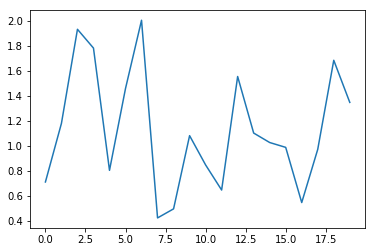

In [122]:
plt.plot(val_res_recon_error)

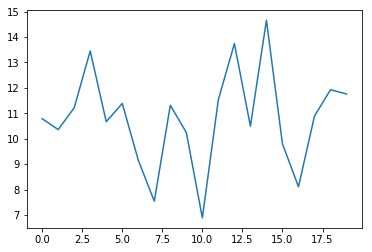

In [124]:
plt.plot(train_res_perplexity)

In [140]:
val_res_recon_error_smooth = savgol_filter(val_res_recon_error, 15, 4)
val_res_perplexity_smooth = savgol_filter(train_res_perplexity, 15, 4)

Text(0.5, 1.0, 'Smoothed Average codebook usage (perplexity).')

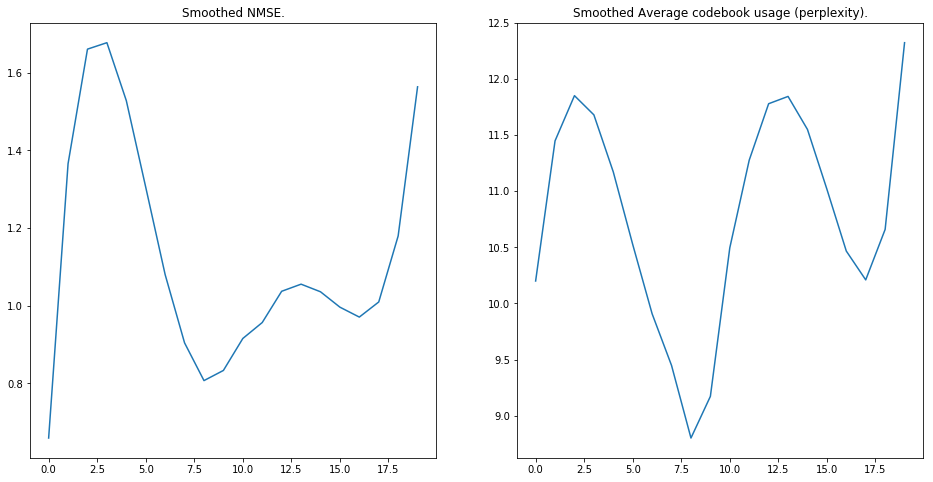

In [141]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(val_res_recon_error_smooth)
#ax.set_yscale('log')
ax.set_title('Smoothed NMSE.')
ax = f.add_subplot(1,2,2)
ax.plot(val_res_perplexity_smooth)
ax.set_title('Smoothed Average codebook usage (perplexity).')

In [127]:
len(val_res_recon_error)

20

In [142]:
optim.Adam?